In [1]:
from dotenv import load_dotenv
load_dotenv()
from os import getenv

import matplotlib.pyplot as plt
import numpy as np
import CoolProp as cp
from scipy import constants
from scipy.integrate import trapezoid
from Laser import util
from datamanager import shotlist
from Pressure import pcb
from CEA import ThermoProps

plt.style.use(['dark_background', './presentationPlots.mplstyle'])
FIGTARGET = getenv('PPTASSETPATH')

In [2]:
MW = 0.03995  # kg/mol, Argon molecular weight
Rg = constants.R/MW  # J/kg K, Argon gas constant

# Constant cp, cv
heat_cap_v = 1.5*Rg
heat_cap_p = 2.5*Rg
gamma = heat_cap_p/heat_cap_v

# INPUT PARAMETERS (STATE 0)
V_0 = 4e-4  # m^3, Total system volume
p_0 = 20e5  # Pa, initial pressure
subvolume_factor = 1/1000000  # Fraction of total volume receiving heat
heat_addition = 30  # J, heat addition by laser
T_0 = 300  # K
m = p_0*V_0/(Rg*T_0)  # kg
rho_0 = m/V_0  # kg/m^3

def printState(label, p=None, T=None, V=None, m=None):
    props = {
        0: ('Pressure', 'bar', 1e-5, '.4f'),
        1: ('Temperature', 'K', 1, '.2f'),
        2: ('Volume', 'mm^3', 1000**3, '.1f'),
        3: ('Mass', 'g', 1000, '.2f'),
    }
    print('STATE {}:'.format(label))
    for i, value in enumerate([p,T,V,m]):
        if value:
            print('{0}: {1:{prec}} {2}'.format(props[i][0], 
                                              value*props[i][2], 
                                              props[i][1],
                                              prec=props[i][3]))

# print('STATE 0:\n{:.2f} K\n{:.2f} kPa'.format(T_0, p_0/1000))
print('cv = {:.2f}J/kg K\ncp = {:.2f} J/kg K'.format(heat_cap_v, heat_cap_p))
printState('0', p=p_0, T=T_0, V=V_0, m=m)

cv = 312.18J/kg K
cp = 520.30 J/kg K
STATE 0:
Pressure: 20.0000 bar
Temperature: 300.00 K
Volume: 400000.0 mm^3
Mass: 12.81 g


### Adding heat at constant volume to a small sub-volume (state 1)

We will now partition a small sub-volume of argon called “A” that has 1/1000 
of the total volume. (The remaining 999/1000 of the gas will be denoted “B”.)

To this region of gas, we will add Q = 30 J of heat at constant volume.

Compute the final temperature and pressure, which we will call state 1.

In [3]:
# STATE 1: Add heat_addition into the subvolume, at constant volume
V_A0 = subvolume_factor*V_0
m_A0 = subvolume_factor*m
m_B0 = (1-subvolume_factor)*m
T_A1 = T_0 + heat_addition/(m_A0*heat_cap_v)
p_A1 = m_A0*Rg*T_A1/V_A0
printState('1 (A)', p=p_A1, T=T_A1, V=V_A0)

STATE 1 (A):
Pressure: 500020.0000 bar
Temperature: 7500300.00 K
Volume: 0.4 mm^3


### Expanding from state 1 to state 2 via isentropic expansion
We will now assume the gas in region A expands into region B isentropically and without heat transfer. We can imagine the two regions are separated by a perfect insulating piston (assume piston occupies no volume or mass). Both the A region and B region must follow $pV^k =$ constant. Find the final volume and temperature of each region so that the pressures are equal in each region. We will call this final state “state 2.”

**Deeper question:** Does the final answer for state 2 depend on the initial volume we deposited heat into? I.e., repeat this calculation if region “A” is 1/100 or 1/10000 of the total volume.

#### Solution method
Set up system of equations:
$$
    \Biggl\{\begin{array}{ccccc}
        p_{\mathrm{A}2}V_{\mathrm{A}2}^\gamma & & &= &p_{\mathrm{A}1}V_{\mathrm{A}1}^\gamma \\
         & & p_{\mathrm{B}2}V_{\mathrm{B}2}^\gamma &= &p_{\mathrm{B}1}V_{\mathrm{B}1}^\gamma \\
        V_{\mathrm{A}2} &+ &V_{\mathrm{B}2} &= &V_0
    \end{array}
$$

Then, since $p_{\mathrm{A}2} + p_{\mathrm{B}2} = p_2$ and $V_{\mathrm{A}2} = V_0 - V_{\mathrm{B}2}$, these can be substituted into the system, reducing it to two equations:
$$
    \biggl\{\begin{array}{ll}
        p_2(V_0 - V_{\mathrm{B}2})^\gamma &= p_{\mathrm{A}1}V_{\mathrm{A}1}^\gamma \\
        p_2V_{\mathrm{B}2}^\gamma &= p_{\mathrm{B}1}V_{\mathrm{B}1}^\gamma
    \end{array}
$$
The second equation can then be re-arranged to substitute it into $p_2$, resulting in an equation that can be solved for $V_{\mathrm{B}2}$:
$$
    p_2 = p_{\mathrm{B}1}V_{\mathrm{B}1}^\gamma V_{\mathrm{B}2}^{-\gamma}
$$
$$
    p_{\mathrm{B}1}V_{\mathrm{B}1}^\gamma V_{\mathrm{B}2}^{-\gamma}(V_0 - V_{\mathrm{B}2})^\gamma = p_{\mathrm{A}1}V_{\mathrm{A}1}^\gamma
$$
Regroup the terms raised to $\gamma$ on one side, and the others on the other side:
$$
    \left(\frac{V_{\mathrm{B}1}(V_0-V_{\mathrm{B}2})}{V_{\mathrm{A}1}V_{\mathrm{B}2}}\right)^\gamma = \frac{p_{\mathrm{A}1}}{p_{\mathrm{B}1}}
$$
Defining the fraction of the total volume taken by A as $\alpha = 1/1000$, $V_{\mathrm{B}1}/V_{\mathrm{A}1}$ can be expressed exclusively in terms of $\alpha$:
$$
    \frac{1-\alpha}{\alpha}\frac{(V_0-V_{\mathrm{B}2})}{V_{\mathrm{B}2}} = \left(\frac{p_{\mathrm{A}1}}{p_{\mathrm{B}1}}\right)^{1/\gamma}
$$
Then, with some algebra, we get a closed-form expression for $V_{\mathrm{B}2}$:
$$
    V_{\mathrm{B}2} = \frac{V_0}{\frac{\alpha}{1-\alpha}\left(\frac{p_{\mathrm{A}1}}{p_{\mathrm{B}1}}\right)^{1/\gamma}+1}
$$

In [4]:
# STATE 2: Expanding A and compressing B isentropically such that both volumes end up at the same pressure
alpharatio = subvolume_factor/(1-subvolume_factor) 
V_B2 = V_0/(alpharatio*(p_A1/p_0)**(1/gamma)+1)
p_2 = p_0*((1-subvolume_factor)*V_0)**gamma * V_B2**-gamma
V_A2 = V_0 - V_B2
T_B2 = p_2*V_B2/(m_B0*Rg)
T_A2 = p_2*V_A2/(m_A0*Rg)
printState('2 (A)', p=p_2, V=V_A2, T=T_A2)
print('')
printState('2 (B)', p=p_2, V=V_B2, T=T_B2)

STATE 2 (A):
Pressure: 20.0145 bar
Temperature: 130623.52 K
Volume: 174.0 mm^3

STATE 2 (B):
Pressure: 20.0145 bar
Temperature: 300.09 K
Volume: 399826.0 mm^3


In [5]:
# Let's define a function to perform the above calc
def state2(alpha):
    V_A0 = alpha*V_0
    m_A0 = alpha*m
    m_B0 = (1-alpha)*m
    T_A1 = T_0 + heat_addition/(m_A0*heat_cap_v)
    p_A1 = m_A0*Rg*T_A1/V_A0
    
    alpharatio = alpha/(1-alpha) 
    V_B2 = V_0/(alpharatio*(p_A1/p_0)**(1/gamma)+1)
    p_2 = p_0*((1-alpha)*V_0)**gamma * V_B2**-gamma
    V_A2 = V_0 - V_B2
    T_B2 = p_2*V_B2/(m_B0*Rg)
    T_A2 = p_2*V_A2/(m_A0*Rg)

    return (p_A1, T_A1), (p_2, T_A2), (p_2, T_B2)

### Heat addition via constant pressure to state 3
In this calculation, we will start over again from state 0 and add 30 J of heat at constant pressure to region A. We can do this by allowing the piston to move as we add heat. In reality, as the piston moves, it will compress region B, but from our answer to the above problem, we don’t expect this to be very significant, so we can neglect for now. Compute the final pressure and temperature in regions A and B, which we will term state 3.

**Deeper question:** Again, does the final answer for state 3 depend on the initial volume we deposited heat into? I.e., repeat this calculation if region “A” is 1/100 or 1/10000 of the total volume.

In [6]:
def state3(alpha):
    m_A0 = alpha*m
    m_B0 = (1-alpha)*m
    V_B0 = (1-alpha)*V_0
    T_A3 = T_0 + heat_addition/(m_A0*heat_cap_p)
    V_A3 = m_A0*Rg*T_A3/p_0
    V_B3 = V_0 - V_A3
    # So... the decrease in volume can either happen with a decrease in temperature
    # (but it can't if we're assuming adiabatic processes) so we compute an isentropic
    # compression anyway even if it doesn't quite make sense with the isobaric heat
    # addition above
    p_B3 = p_0*(V_B0/V_B3)**gamma
    T_B3 = p_B3*V_B3/(m_B0*Rg)

    return (p_0, T_A3, V_A3), (p_B3, T_B3, V_B3)

state_A3, state_B3 = state3(subvolume_factor)
printState('3 (A)', *state_A3)
printState('3 (B)', *state_B3)

STATE 3 (A):
Pressure: 20.0000 bar
Temperature: 4500300.00 K
Volume: 6000.4 mm^3
STATE 3 (B):
Pressure: 20.5102 bar
Temperature: 303.04 K
Volume: 393999.6 mm^3


### Uniform heat addition to entire volume (state 4)

Finally, assume that the 30 J is added to entire initial volume (not just to region A) at constant volume. Compute the final pressure and temperature of argon. This should be the final state of any process after the heat is uniformly distributed through the entire volume of argon. Find the pressure and temperature of this state (state 4).

In [7]:
def state4():
    T_4 = T_0 + heat_addition/(m*heat_cap_v)
    p_4 = m*Rg*T_4/V_0
    return (p_4, T_4)

printState('4', *state4())

STATE 4:
Pressure: 20.5000 bar
Temperature: 307.50 K


### Calculation Summary

Repeating these for different $\alpha$ values

In [8]:
p_0 = 20e5
heat_addition = 30
results = {}
alphas = ['1/1000', '1/100', '1/10000', '1/100000']
statelabels =['A1', 'A2', 'B2', 'A3', 'B3', '4']
for a in alphas:
    alphaval = eval(a)
    sA1, sA2, sB2 = state2(alphaval)
    sA3, sB3 = state3(alphaval)
    s4 = state4()
    results[a] = dict(zip(statelabels, [sA1, sA2, sB2, sA3, sB3, s4]))

print('       |'+ ' |'.join(['   p [kPa]     T [K]']*len(alphas)))
print('STATE  |'+ ' |'.join(['{:>20}'.format('V_A/V_0 = '+a) for a in alphas]))
print('-------|'+ '-|'.join(['-'*20]*len(alphas)))
for s in statelabels:
    print('{label:7}|'.format(label=s)+' |'.join(['{p:>10.2f}{T:>10.2f}'.format(p=results[a][s][0]/1000, T=results[a][s][1]) for a in alphas]))

       |   p [kPa]     T [K] |   p [kPa]     T [K] |   p [kPa]     T [K] |   p [kPa]     T [K]
STATE  |    V_A/V_0 = 1/1000 |     V_A/V_0 = 1/100 |   V_A/V_0 = 1/10000 |  V_A/V_0 = 1/100000
-------|---------------------|---------------------|---------------------|--------------------
A1     |  52000.00   7800.00 |   7000.00   1050.00 | 502000.00  75300.00 |5002000.00 750300.00
A2     |   2020.25   2127.43 |   2037.49    640.90 |   2008.85   8273.56 |   2003.61  32832.43
B2     |   2020.25    301.21 |   2037.49    302.24 |   2008.85    300.53 |   2003.61    300.22
A3     |   2000.00   4800.00 |   2000.00    750.00 |   2000.00  45300.00 |   2000.00 450300.00
B3     |   2051.07    303.04 |   2051.54    303.07 |   2051.02    303.04 |   2051.02    303.04
4      |   2050.00    307.50 |   2050.00    307.50 |   2050.00    307.50 |   2050.00    307.50


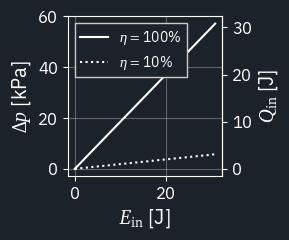

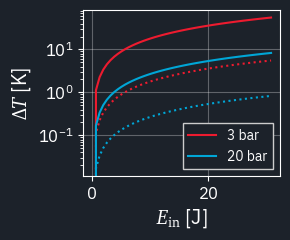

In [15]:
# Modelling for Barry
V = 315*np.pi*(38.1/2)**2*0.001**3  # m^3, Test section internal volume 
mass = lambda pinit: pinit*V/(Rg*290)
Ein = np.linspace(0, 30.8)  # J, laser energy in
deltap = lambda eta: Qtop(eta*Ein)
ptoQ = lambda p: p*(V*heat_cap_v*1000)/Rg
Qtop = lambda Q: Rg*Q/(V*heat_cap_v*1000)
ptoT = lambda p, p0: ptoQ(p)/(mass(p0)*heat_cap_v)
fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(Ein, deltap(1), 'w', label=r'$\eta =$100%')
# plt.plot(Ein, deltap(0.5), 'w--', label=r'$\eta =$50%')
plt.plot(Ein, deltap(0.1), 'w:', label=r'$\eta =$10%')
ax02 = ax.secondary_yaxis('right', functions=(ptoQ, Qtop))
ax02.set_ylabel(r'$Q_\mathrm{in}$ [J]')
plt.xlabel(r'$E_\mathrm{in}$ [J]')
plt.ylabel(r'$\Delta p$ [kPa]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(FIGTARGET+'heatdep_static.svg')

fig2, ax2 = plt.subplots(figsize=(3,2.5))
plt.semilogy(Ein, ptoT(deltap(1), 3e5), 'C0', label=r'3 bar')
plt.semilogy(Ein, ptoT(deltap(0.1), 3e5), 'C0:')
plt.semilogy(Ein, ptoT(deltap(1), 20e5), 'C1', label=r'20 bar')
plt.semilogy(Ein, ptoT(deltap(0.1), 20e5), 'C1:')
plt.xlabel(r'$E_\mathrm{in}$ [J]')
plt.ylabel(r'$\Delta T$ [K]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(FIGTARGET+'heatdep_T_static.svg')


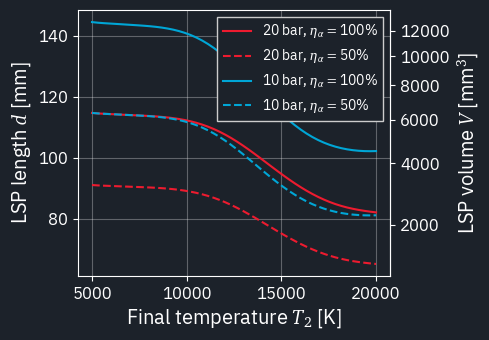

In [10]:
# Estimating LSP size
beam_f = 0.2  # m
beam_D = 0.0254  # m, initial beam diameter
beam_N = beam_f/beam_D

argon_10 = ThermoProps(10)
argon_20 = ThermoProps(20)
# argon_3 = ThermoProps(3)

beam_r = lambda x: x/(2*beam_N)  # m, radius away from focus
beam_l = lambda r: 2*beam_N*r
LSP_V = lambda x: np.pi*beam_r(x)**2*x/3
LSP_l = lambda V: (12*V*beam_N**2/np.pi)**(1/3)
Ti = 290
Tf = np.linspace(5000, 20000)
Qin = 30
fig_se, ax_se1 = plt.subplots(figsize=(5,3.5))
for i, gas in enumerate([argon_20, argon_10]):
    fmt = 'C'
    fmt += str(i)
    for eta in [1, 0.5]:
        m = Qin*eta/(gas.h(Tf)-gas.h(Ti))
        volume = m/gas.rho(Tf)
        fmt += '--' if eta == 0.5 else ''
        plt.plot(Tf, LSP_l(volume*1000**3), fmt,
                 label='{:.0f} bar, ${} =${:.0f}%'.format(
                     gas.p*1e-5, 
                     r'\eta_\alpha', 
                     eta*100
                     ))
plt.xlabel(r'Final temperature $T_2$ [K]')
plt.ylabel(r'LSP length $d$ [mm]')
# plt.ylim(10,2e2)
plt.legend()
plt.grid(which='both')
ax_se2 = ax_se1.secondary_yaxis('right', functions=(LSP_V, LSP_l))
ax_se2.set_ylabel(r'LSP volume $V$ [mm$^3$]')
plt.tight_layout()
# plt.savefig('../report/assets/4 models/volume_est.pdf')